<a href="https://colab.research.google.com/github/Jalapinho1/Deep-Reinforcement-Learning-Explained/blob/main/RFL_Blackjack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Monte Carlo Methods**

Exploration-Explanation Dilemma


In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict
env = gym.make('Blackjack-v0')
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


We’ll use OpenAI’s gym Environment Blackjack-v0. Each state is a 3-tuple of:
* the player’s current sum ∈{0,1,…,31}
* the dealer’s face-up card ∈{1,…,10}
* whether or not the player has a usable ace.

The Agent has two potential actions:

* Stick (action 0): take no more cards (also know as “stand” or “stay”).
* Hit (action 1): take another card from the dealer.

Each game of blackjack is an episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards within a game are 0, and we do not discount (gamma = 1); therefore these terminal rewards are also the returns.

In [24]:
state = env.reset()
while True:
       print(state)
       action = env.action_space.sample()
       state, reward, done, info = env.step(action)
       print('Action: ', action, '\n')
       if done:
          if reward > 0: 
             print('Reward: ', reward, '(Player won)\n')
             print('Final state is', state,'\n')
          else: 
             print('Reward: ', reward, '(Player lost)\n')
             print('Final state is', state,'\n')
          break

(20, 10, False)
Action:  0 

Reward:  0.0 (Player lost)

Final state is (20, 10, False) 



**A simple MC Prediction implementation**


In [27]:
def generate_episode(env):
    episode = []
    state = env.reset() 
    while True:
        probs = [0.75, 0.25] if state[0] > 18 else [0.25, 0.75]
        action = np.random.choice(np.arange(2), p=probs)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
           break
    return episode

In [28]:
for i in range(10):
    print(generate_episode(env))

[((9, 10, False), 1, 0.0), ((13, 10, False), 1, 0.0), ((18, 10, False), 1, -1.0)]
[((16, 5, True), 1, 0.0), ((21, 5, True), 0, 1.0)]
[((15, 5, False), 1, 0.0), ((17, 5, False), 1, -1.0)]
[((10, 5, False), 1, 0.0), ((13, 5, False), 1, 0.0), ((17, 5, False), 0, 1.0)]
[((5, 10, False), 1, 0.0), ((15, 10, False), 1, 0.0), ((19, 10, False), 0, 0.0)]
[((18, 2, False), 0, 1.0)]
[((8, 8, False), 0, 1.0)]
[((5, 10, False), 0, -1.0)]
[((17, 7, False), 0, -1.0)]
[((5, 10, False), 0, -1.0)]


In [41]:
episode = generate_episode(env)
print (episode)
states, actions, rewards = zip(*episode)
for i, state in enumerate(states):
  print('state:  ',state, '\n')
print('states:  ',states)
print('actions: ', actions)
print('rewards: ', rewards)

[((12, 8, False), 1, -1.0)]
state:   (12, 8, False) 

states:   ((12, 8, False),)
actions:  (1,)
rewards:  (-1.0,)


**Q**: A Q-table with a row for each state and a column for each action.

**N** : A table that keeps track of the number of first visits we have made to each state-action pair.

**returns_sum**: A table that keeps track of the sum of the rewards obtained after first visits to each state-action pair.

In [34]:
def mc_prediction(env, num_episodes, generate_episode, gamma=1.0):
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for episode in range(1, num_episodes+1):
        
        if episode % 10000 == 0: # monitor progress
            print("\repisode {}/{}.".format(episode, num_episodes), end="")
            sys.stdout.flush()
        
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)

        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

In [35]:
num_episodes=1000000

Q = mc_prediction(env, num_episodes, generate_episode)

episode 1000000/1000000.

In [43]:
def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

In [ ]:
pretty(State_Value_table)

In [ ]:
State_Value_table={}
for state, actions in Q.items():
     print('state', state, ' action', action, '\n')
     State_Value_table[state]= (state[0]>18)*(np.dot([0.75, 0.25],actions)) + (state[0]<=18)*(np.dot([0.75, 0.25],actions))

In [37]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

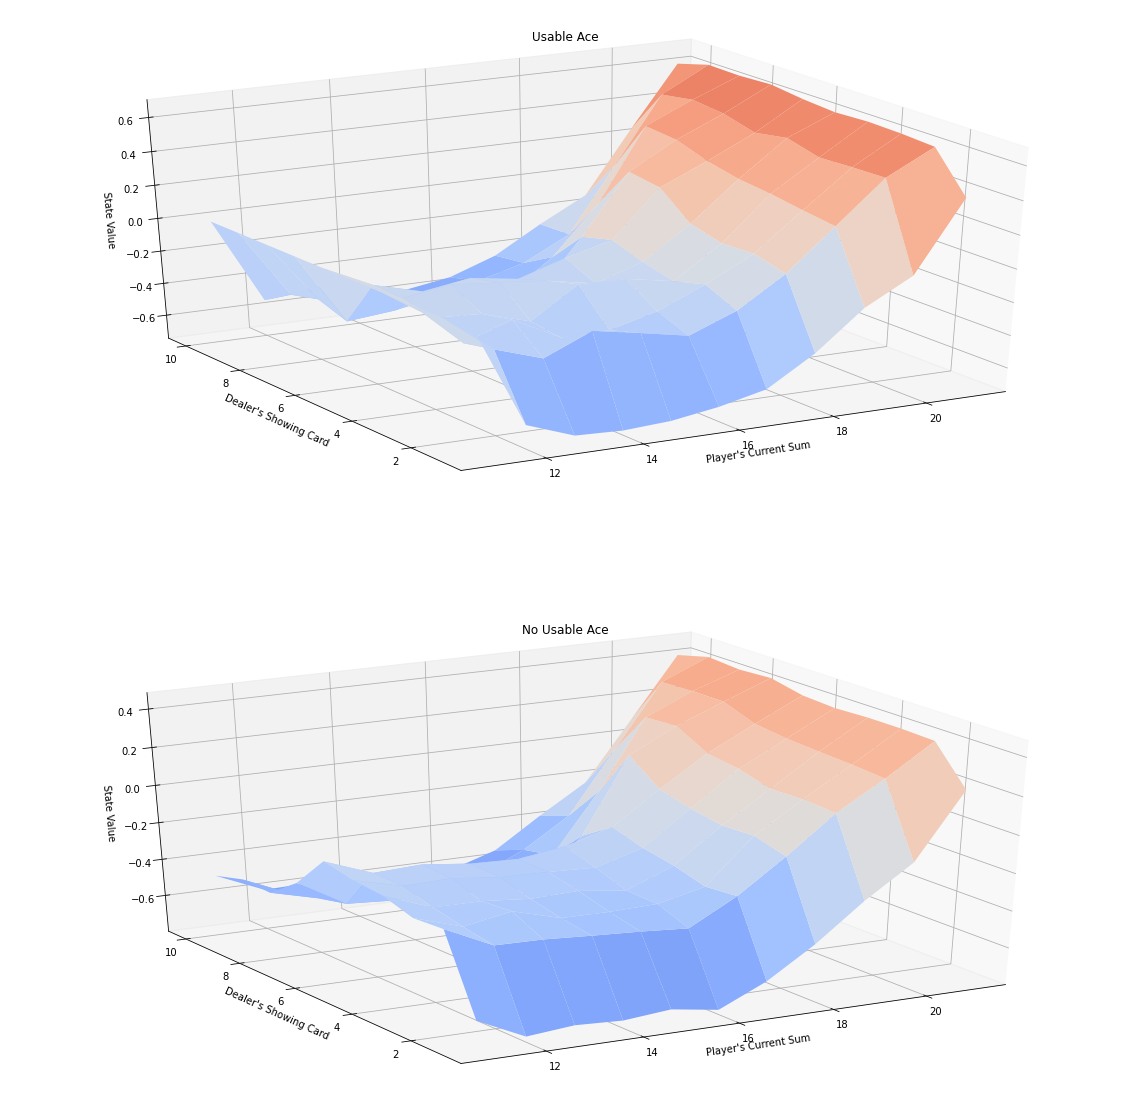

In [38]:
plot_blackjack_values(State_Value_table)

But in either case, we see that the highest state values correspond to when the player sum is something like 20 or 21, and it seems obvious because in this case we are most likely to win the game.